<a href="https://colab.research.google.com/github/ZwwWayne/mmdetection/blob/update-colab/demo/MMDet_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import copy
import os.path as osp

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module()
class VisDroneDataset(CustomDataset):

    CLASSES = ('car', 'truck', 'bus')

    def load_annotations(self, ann_file):
        cat2label = {k: i for i, k in enumerate(self.CLASSES)}
        # load image list from file
        image_list = mmcv.list_from_file(self.ann_file)
    
        data_infos = []
        # convert annotations to middle format
        for image_id in image_list:
            filename = f'{self.img_prefix}/{image_id}.jpg'
            image = mmcv.imread(filename)
            height, width = image.shape[:2]
    
            data_info = dict(filename=f'{image_id}.jpg', width=width, height=height)
    
            # load annotations
            label_prefix = self.img_prefix.replace('images', 'VisDronetxt')
            lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))
    
            content = [line.strip().split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            bboxes = [[float(info) for info in x[4:8]] for x in content]
    
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
    
            # filter 'DontCare'
            for bbox_name, bbox in zip(bbox_names, bboxes):
                if bbox_name in cat2label:
                    gt_labels.append(cat2label[bbox_name])
                    gt_bboxes.append(bbox)
                else:
                    gt_labels_ignore.append(-1)
                    gt_bboxes_ignore.append(bbox)

            data_anno = dict(
                bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                labels=np.array(gt_labels, dtype=np.long),
                bboxes_ignore=np.array(gt_bboxes_ignore,
                                       dtype=np.float32).reshape(-1, 4),
                labels_ignore=np.array(gt_labels_ignore, dtype=np.long))

            data_info.update(ann=data_anno)
            data_infos.append(data_info)

        return data_infos

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [2]:
from mmcv import Config
cfg = Config.fromfile('./configs/empirical_attention/faster_rcnn_r50_fpn_attention_1111_dcn_1x_coco.py')

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [3]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VisDroneDataset'
cfg.data_root = 'data/coco/'

cfg.data.train.type = 'VisDroneDataset'
cfg.data.train.data_root ='data/coco/'
cfg.data.train.ann_file = 'ImageSets/Main/train.txt'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'VisDroneDataset'
cfg.data.val.data_root = 'data/coco/'
cfg.data.val.ann_file = 'ImageSets/Main/val.txt'
cfg.data.val.img_prefix = 'images'

cfg.data.test.type = 'VisDroneDataset'
cfg.data.test.data_root = 'data/coco/'
cfg.data.test.ann_file = 'ImageSets/Main/val.txt'
cfg.data.test.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 3
# We can still use the pre-trained Mask RCNN model though we do not need to

# use the mask branch
'''
cfg.load_from = './work_dirs/faster_rcnn/epoch_400.pth'
'''


# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/faster_rcnn_attention'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None

#iter100,打印一次loss, loss_cls, loss_bbox, acc结果, 一个epoch 141 iter则一个epoch打印1次，1410iter打印10次
cfg.log_config.interval = 100

#设置评估指标coco-style使用bbox, voc-style使用mAP
cfg.evaluation.metric = 'mAP'
#设置评估模型的epoch数
cfg.evaluation.interval = 5
#设置保存checkpoints的epoch数
cfg.checkpoint_config.interval = 10

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='FasterRCNN',
    pretrained='torchvision://resnet50',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        plugins=[
            dict(
                cfg=dict(
                    type='GeneralizedAttention',
                    spatial_range=-1,
                    num_heads=8,
                    attention_type='1111',
                    kv_stride=2),
                stages=(False, False, True, True),
                position='after_conv2')
        ],
        dcn=dict(type='DCN', deform_groups=1, fallback_on_stride=False),
        stage_with_dcn=(False, True, True, True)),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_chann

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [4]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

/home/htang/1Projects/mmdetection-master/mmdet/datasets/custom.py:153: UserWarning: CustomDataset does not support filtering empty gt images.
  'CustomDataset does not support filtering empty gt images.')
2020-11-24 18:51:16,436 - mmdet - INFO - load model from: torchvision://resnet50
2020-11-24 18:51:16,587 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

missing keys in source state_dict: layer2.0.conv2.conv_offset.weight, layer2.0.conv2.conv_offset.bias, layer2.1.conv2.conv_offset.weight, layer2.1.conv2.conv_offset.bias, layer2.2.conv2.conv_offset.weight, layer2.2.conv2.conv_offset.bias, layer2.3.conv2.conv_offset.weight, layer2.3.conv2.conv_offset.bias, layer3.0.conv2.conv_offset.weight, layer3.0.conv2.conv_offset.bias, layer3.0.gen_attention_block.appr_bias, layer3.0.gen_attention_block.geom_bias, layer3.0.gen_attention_block.gamma, layer3.0.gen_attention_block.query_conv.weight, layer3.0.gen_attenti

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 12.0 task/s, elapsed: 6s, ETA:     0s

2020-11-24 18:56:24,921 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2646 | 0.807  | 0.758 |
| truck | 88   | 421  | 0.523  | 0.159 |
| bus   | 83   | 548  | 0.627  | 0.285 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.401 |
+-------+------+------+--------+-------+
2020-11-24 18:56:24,922 - mmdet - INFO - Epoch(val) [5][141]	mAP: 0.4008
2020-11-24 18:57:08,343 - mmdet - INFO - Epoch [6][100/141]	lr: 2.500e-03, eta: 0:25:58, time: 0.434, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0462, loss_rpn_bbox: 0.0851, loss_cls: 0.2534, acc: 89.9980, loss_bbox: 0.4266, loss: 0.8113
2020-11-24 18:58:13,075 - mmdet - INFO - Epoch [7][100/141]	lr: 2.500e-03, eta: 0:25:16, time: 0.462, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0424, loss_rpn_bbox: 0.0801, loss_cls: 0.2308, acc: 90.9131, loss_bbox: 0.4029, loss: 0.7562
2020-11-24 18:59:16,994 - mmde

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 12.2 task/s, elapsed: 6s, ETA:     0s

2020-11-24 19:01:48,288 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2522 | 0.823  | 0.790 |
| truck | 88   | 544  | 0.705  | 0.248 |
| bus   | 83   | 388  | 0.747  | 0.482 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.507 |
+-------+------+------+--------+-------+
2020-11-24 19:01:48,289 - mmdet - INFO - Epoch(val) [10][141]	mAP: 0.5070
2020-11-24 19:02:33,804 - mmdet - INFO - Epoch [11][100/141]	lr: 2.500e-03, eta: 0:22:16, time: 0.455, data_time: 0.023, memory: 3066, loss_rpn_cls: 0.0309, loss_rpn_bbox: 0.0675, loss_cls: 0.1723, acc: 93.2998, loss_bbox: 0.3338, loss: 0.6044
2020-11-24 19:03:37,485 - mmdet - INFO - Epoch [12][100/141]	lr: 2.500e-03, eta: 0:21:32, time: 0.461, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0273, loss_rpn_bbox: 0.0619, loss_cls: 0.1633, acc: 93.6807, loss_bbox: 0.3211, loss: 0.5736
2020-11-24 19:04:41,867 - m

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 11.5 task/s, elapsed: 6s, ETA:     0s

2020-11-24 19:07:19,775 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 2062 | 0.796  | 0.776 |
| truck | 88   | 418  | 0.636  | 0.354 |
| bus   | 83   | 433  | 0.723  | 0.550 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.560 |
+-------+------+------+--------+-------+
2020-11-24 19:07:19,776 - mmdet - INFO - Epoch(val) [15][141]	mAP: 0.5604
2020-11-24 19:08:04,352 - mmdet - INFO - Epoch [16][100/141]	lr: 2.500e-03, eta: 0:18:34, time: 0.446, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0200, loss_rpn_bbox: 0.0571, loss_cls: 0.1282, acc: 95.0479, loss_bbox: 0.2788, loss: 0.4841
2020-11-24 19:09:07,594 - mmdet - INFO - Epoch [17][100/141]	lr: 2.500e-03, eta: 0:17:48, time: 0.457, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0196, loss_rpn_bbox: 0.0573, loss_cls: 0.1203, acc: 95.1680, loss_bbox: 0.2698, loss: 0.4671
2020-11-24 19:10:15,272 - m

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 11.8 task/s, elapsed: 6s, ETA:     0s

2020-11-24 19:12:52,251 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1951 | 0.785  | 0.764 |
| truck | 88   | 381  | 0.625  | 0.320 |
| bus   | 83   | 408  | 0.711  | 0.607 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.563 |
+-------+------+------+--------+-------+
2020-11-24 19:12:52,252 - mmdet - INFO - Epoch(val) [20][141]	mAP: 0.5634
2020-11-24 19:13:39,109 - mmdet - INFO - Epoch [21][100/141]	lr: 2.500e-03, eta: 0:14:51, time: 0.468, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0174, loss_rpn_bbox: 0.0516, loss_cls: 0.1097, acc: 95.8086, loss_bbox: 0.2520, loss: 0.4307
2020-11-24 19:14:42,743 - mmdet - INFO - Epoch [22][100/141]	lr: 2.500e-03, eta: 0:14:04, time: 0.457, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0150, loss_rpn_bbox: 0.0515, loss_cls: 0.1063, acc: 96.0127, loss_bbox: 0.2464, loss: 0.4193
2020-11-24 19:15:45,942 - m

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 11.7 task/s, elapsed: 6s, ETA:     0s

2020-11-24 19:18:14,904 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1959 | 0.772  | 0.754 |
| truck | 88   | 426  | 0.500  | 0.336 |
| bus   | 83   | 394  | 0.602  | 0.464 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.518 |
+-------+------+------+--------+-------+
2020-11-24 19:18:14,905 - mmdet - INFO - Epoch(val) [25][141]	mAP: 0.5180
2020-11-24 19:19:00,899 - mmdet - INFO - Epoch [26][100/141]	lr: 2.500e-03, eta: 0:10:58, time: 0.460, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0132, loss_rpn_bbox: 0.0492, loss_cls: 0.0963, acc: 96.3662, loss_bbox: 0.2240, loss: 0.3827
2020-11-24 19:20:02,042 - mmdet - INFO - Epoch [27][100/141]	lr: 2.500e-03, eta: 0:10:11, time: 0.439, data_time: 0.023, memory: 3066, loss_rpn_cls: 0.0127, loss_rpn_bbox: 0.0446, loss_cls: 0.0892, acc: 96.7939, loss_bbox: 0.2062, loss: 0.3527
2020-11-24 19:21:03,489 - m

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 11.9 task/s, elapsed: 6s, ETA:     0s

2020-11-24 19:23:30,216 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1968 | 0.776  | 0.757 |
| truck | 88   | 504  | 0.545  | 0.349 |
| bus   | 83   | 460  | 0.687  | 0.608 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.571 |
+-------+------+------+--------+-------+
2020-11-24 19:23:30,218 - mmdet - INFO - Epoch(val) [30][141]	mAP: 0.5713
2020-11-24 19:24:16,511 - mmdet - INFO - Epoch [31][100/141]	lr: 2.500e-04, eta: 0:07:05, time: 0.463, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0100, loss_rpn_bbox: 0.0338, loss_cls: 0.0694, acc: 97.4795, loss_bbox: 0.1690, loss: 0.2821
2020-11-24 19:25:18,631 - mmdet - INFO - Epoch [32][100/141]	lr: 2.500e-04, eta: 0:06:19, time: 0.446, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0115, loss_rpn_bbox: 0.0353, loss_cls: 0.0716, acc: 97.5342, loss_bbox: 0.1691, loss: 0.2876
2020-11-24 19:26:19,919 - m

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 11.2 task/s, elapsed: 6s, ETA:     0s

2020-11-24 19:28:47,937 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1997 | 0.771  | 0.755 |
| truck | 88   | 526  | 0.534  | 0.350 |
| bus   | 83   | 471  | 0.687  | 0.611 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.572 |
+-------+------+------+--------+-------+
2020-11-24 19:28:47,938 - mmdet - INFO - Epoch(val) [35][141]	mAP: 0.5720
2020-11-24 19:29:35,579 - mmdet - INFO - Epoch [36][100/141]	lr: 2.500e-04, eta: 0:03:16, time: 0.476, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0092, loss_rpn_bbox: 0.0325, loss_cls: 0.0654, acc: 97.7881, loss_bbox: 0.1574, loss: 0.2645
2020-11-24 19:30:39,241 - mmdet - INFO - Epoch [37][100/141]	lr: 2.500e-04, eta: 0:02:30, time: 0.459, data_time: 0.024, memory: 3066, loss_rpn_cls: 0.0101, loss_rpn_bbox: 0.0329, loss_cls: 0.0613, acc: 97.8105, loss_bbox: 0.1555, loss: 0.2599
2020-11-24 19:31:42,863 - m

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 71/71, 10.9 task/s, elapsed: 6s, ETA:     0s

2020-11-24 19:34:21,213 - mmdet - INFO - 
+-------+------+------+--------+-------+
| class | gts  | dets | recall | ap    |
+-------+------+------+--------+-------+
| car   | 1631 | 1955 | 0.768  | 0.752 |
| truck | 88   | 519  | 0.557  | 0.349 |
| bus   | 83   | 465  | 0.675  | 0.592 |
+-------+------+------+--------+-------+
| mAP   |      |      |        | 0.565 |
+-------+------+------+--------+-------+
2020-11-24 19:34:21,215 - mmdet - INFO - Epoch(val) [40][141]	mAP: 0.5647


### Understand the log
From the log, we can have a basic understanding the training process and know how well the detector is trained.

Firstly, the ResNet-50 backbone pre-trained on ImageNet is loaded, this is a common practice since training from scratch is more cost. The log shows that all the weights of the ResNet-50 backbone are loaded except the `conv1.bias`, which has been merged into `conv.weights`.

Second, since the dataset we are using is small, we loaded a Mask R-CNN model and finetune it for detection. Because the detector we actually using is Faster R-CNN, the weights in mask branch, e.g. `roi_head.mask_head`, are `unexpected key in source state_dict` and not loaded.
The original Mask R-CNN is trained on COCO dataset which contains 80 classes but KITTI Tiny dataset only have 3 classes. Therefore, the last FC layer of the pre-trained Mask R-CNN for classification has different weight shape and is not used.

Third, after training, the detector is evaluated by the default VOC-style evaluation. The results show that the detector achieves 54.1 mAP on the val dataset,
 not bad!

## Test the trained detector

After finetuning the detector, let's visualize the prediction results!

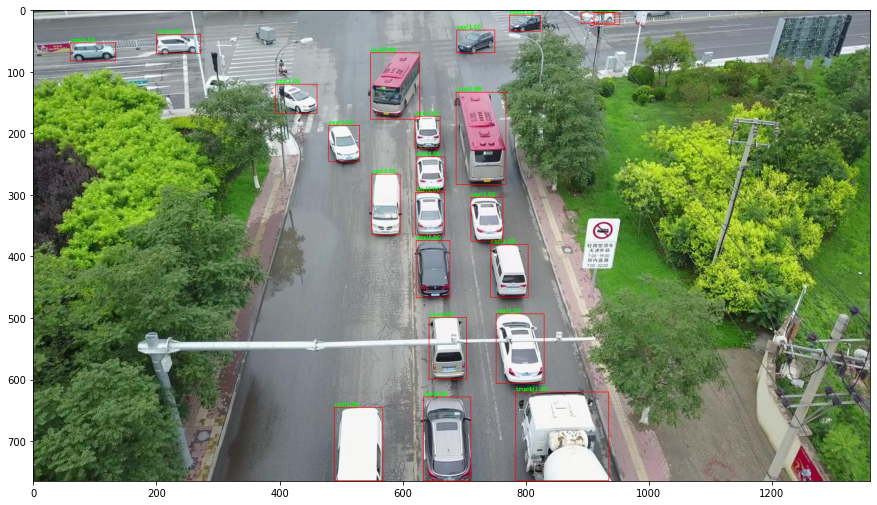

In [5]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot

img = mmcv.imread('testImages/test.jpg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)


# 计算bbox/mAP

In [6]:
%run tools/test.py ./configs/empirical_attention/faster_rcnn_r50_fpn_attention_1111_dcn_1x_coco.py ./work_dirs/faster_rcnn_attention/latest.pth  --out out/aver.pkl --eval bbox --show

# 分析训练日志

plot curve of ./work_dirs/faster_rcnn_attention/None.log.json, metric is loss_cls


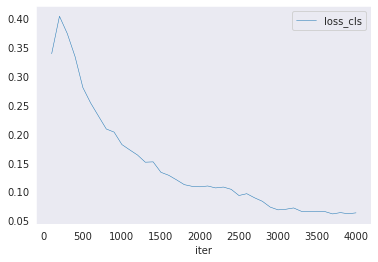

In [12]:
#绘制分类损失
%run tools/analyze_logs.py plot_curve ./work_dirs/faster_rcnn_attention/None.log.json --keys loss_cls --legend loss_cls

plot curve of ./work_dirs/faster_rcnn_attention/None.log.json, metric is loss_bbox


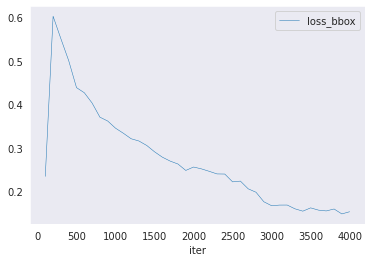

In [13]:
#回归损失
%run tools/analyze_logs.py plot_curve ./work_dirs/faster_rcnn_attention/None.log.json --keys loss_bbox --legend loss_bbox

plot curve of ./work_dirs/faster_rcnn_attention/None.log.json, metric is loss


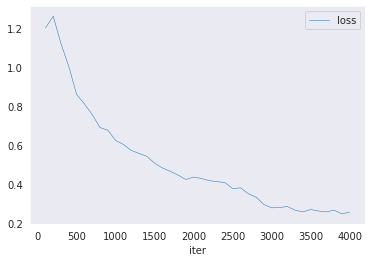

In [14]:
#总损失
%run tools/analyze_logs.py plot_curve ./work_dirs/faster_rcnn_attention/None.log.json --keys loss --legend loss

plot curve of ./work_dirs/faster_rcnn_attention/None.log.json, metric is acc


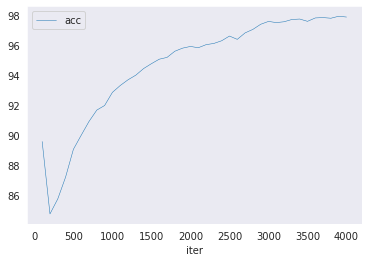

In [15]:
#精度
%run tools/analyze_logs.py plot_curve ./work_dirs/faster_rcnn_attention/None.log.json --keys acc --legend acc

plot curve of ./work_dirs/faster_rcnn_attention/None.log.json, metric is loss_cls
plot curve of ./work_dirs/faster_rcnn_attention/None.log.json, metric is loss_bbox
plot curve of ./work_dirs/faster_rcnn_attention/None.log.json, metric is loss
save curve to: ./work_dirs/faster_rcnn_attention/losses.pdf
plot curve of ./work_dirs/faster_rcnn_attention/None.log.json, metric is acc
save curve to: ./work_dirs/faster_rcnn_attention/acc.pdf


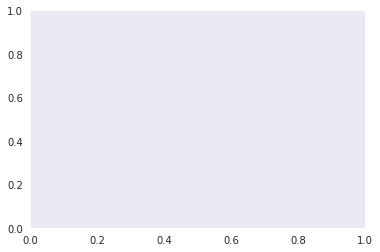

In [17]:
#多曲线保存为pdf输出
%run tools/analyze_logs.py plot_curve ./work_dirs/faster_rcnn_attention/None.log.json --keys loss_cls loss_bbox loss --out ./work_dirs/faster_rcnn_attention/losses.pdf
%run tools/analyze_logs.py plot_curve ./work_dirs/faster_rcnn_attention/None.log.json --keys acc --out ./work_dirs/faster_rcnn_attention/acc.pdf